In [1]:
import gymnasium as gym
import gym_donkeycar

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Preprocessing

""" transformation: scale pixel values and resize the shape """
transform = transforms.Compose([
    transforms.ToTensor(), # -> scaled to [0,1]
    transforms.Lambda(lambda x: x.to(device)), # Move to device
    transforms.Resize((128, 128)), # 3x128x128
])

In [4]:
torch. __version__

'1.12.1+cu116'

(120, 160, 3)


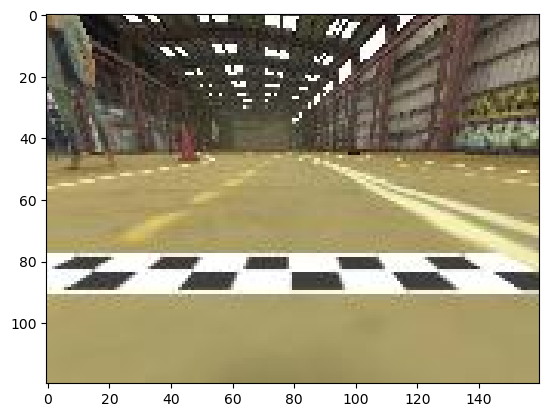

In [5]:
obs = np.load("obs.npy")
print(obs.shape)
plt.imshow(obs)

In [20]:
class ConvBlock(nn.Module):
    """ Use this block to change the number of channels. """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class TransposeConvBlock(nn.Module):
    """ Use this block to change the number of channels and perform a deconvolution
        followed by batchnorm and a relu activation. """
    def __init__(self, in_channels, out_channels):
        super(TransposeConvBlock, self).__init__()
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ResConvBlock(nn.Module):
    """ This block needs the same number input and output channels.
        It performs three convolutions with batchnorm, relu 
        and then adds a skip connection. """
    def __init__(self, in_channels, out_channels):
        super(ResConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        x += residual
        x = self.relu(x)      
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, greyscale=True):
        super(Autoencoder, self).__init__()

        if greyscale:
            self.input_channels = 1
        else:
            self.input_channels = 3
        
        self.encoder = nn.Sequential(
            ConvBlock(self.input_channels, 16),
            ResConvBlock(16, 16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(16, 32),
            ResConvBlock(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(32, 64),
            ResConvBlock(64, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(64, 128),
            ResConvBlock(128, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(128, 256),
            ResConvBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResConvBlock(256, 256),
            ConvBlock(256, 2),
        )

        self.decoder = nn.Sequential(
            TransposeConvBlock(2, 32),
            ResConvBlock(32, 32),
            
            TransposeConvBlock(32, 64),
            ResConvBlock(64, 64),
            
            TransposeConvBlock(64, 128),
            ResConvBlock(128, 128),
            
            TransposeConvBlock(128, 256),
            ResConvBlock(256, 256),
            
            TransposeConvBlock(256, 512),
            ResConvBlock(512, 512),
            
            ResConvBlock(512, 512),
            ConvBlock(512, 32),
            ConvBlock(32, self.input_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_loss(self, x, yhat):
        return F.mse_loss(yhat, x)

    def save_weights(self):
        torch.save(self.state_dict(), "AE")
    
    def load_weights(self, path, eval_mode=True):
        self.load_state_dict(torch.load(path))
        if eval_mode:
            print("Set AE to evaluation mode.")
            self.eval()
        
    def get_num_params(self):
        return sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

autoencoder = Autoencoder(greyscale=True).to(device)
autoencoder_criterion = nn.MSELoss()

autoencoder_optim = optim.Adam(
    autoencoder.parameters(), 
    lr=3e-4, 
    weight_decay=1e-5 # l2 regularization
)

print(autoencoder.get_num_params())

21897945


In [27]:
# create a VAE with a latent size of 10 and 10 categories
vae = VAE(latent_size=10, num_classes=10).to(device)

# define the optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

x = transform(obs)

# train the VAE for 10 epochs
for i in range(10):
    
    
    optimizer.zero_grad()
    
    reconstruction, z_mean, z_logvar, c_logits = vae(x)
    loss = vae.get_loss(reconstruction, x, z_mean, z_logvar, c_logits)
    loss.backward()
    optimizer.step()
    print(loss.item())

ValueError: Using a target size (torch.Size([3, 128, 128])) that is different to the input size (torch.Size([4, 3, 128, 128])) is deprecated. Please ensure they have the same size.

In [24]:
reconstruction, z_mean, z_logvar, c_logits = vae(x)

In [28]:
reconstruction.shape

torch.Size([4, 3, 128, 128])

In [ ]:
[4, 3, 64, 64]

In [38]:
m = Categorical(torch.ones(32,32)) # logits for the distribution must be between 0-1, so use a sigmoid

In [39]:
m.sample()

tensor([11, 18, 27, 25, 20, 27, 10, 23,  5, 20,  8,  6, 20, 15, 15,  4,  5, 31,
         8, 27, 16, 26, 15,  6,  6, 11,  5, 21, 15, 14,  6,  0])